In [19]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [21]:
#from tensorflow.keras import models
#from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [22]:
df_input = pd.read_csv("CD3D_110℃_whole", usecols=[1,2,3,4])

In [41]:
df_output = pd. read_csv("CD3D_110℃_whole", usecols=[5])
df_output = df_output*1e4

In [24]:
df_input.shape

(158681, 4)

In [25]:
df_output.shape

(158681, 1)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.1, random_state=0)  #testとvalidとtrainにさらに分ける必要あり

In [27]:
print(x_train.shape,x_test.shape)

(142812, 4) (15869, 4)


In [28]:
x_train

,x座標,y座標,z座標,V[V]
106707,0.000208,0.02145,0.001165,0.70
125796,0.000969,0.02115,0.001165,0.80
136463,0.000000,0.02235,0.001175,0.95
138252,0.001385,0.01605,0.001180,0.95
39964,0.000000,0.00675,0.001172,0.40
...,...,...,...,...
97639,0.001385,0.01935,0.001165,0.75
95939,0.001246,0.02115,0.001180,0.75
152315,0.001108,0.01350,0.001180,1.00
117952,0.000277,0.01890,0.001165,0.85


In [43]:
y_train

,i[A/m^2]
106707,1672.148911
125796,512.020040
136463,14.331918
138252,14.480590
39964,7835.182922
...,...
97639,1010.984717
95939,1009.789778
152315,3.280651
117952,202.213129


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers, initializers

model = Sequential()

weights = [com.get_weights() for com in model.layers[0:]]  #重さを抽出（※始めに回すときだけ下の行と入れ替える）



model.add(Dense(units=16, input_shape=(4,), activation='relu'))  
model.add(Dense(units=8, activation='relu'))  #
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))  #隠れ層3層でやってみる

model.compile(loss='mean_absolute_error',    
              optimizer='adam',             #とりあえずadamで
              metrics=['mae'],
              run_eagerly=False)   #計算時間5倍くらいかかる

In [45]:
callbacks1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae',
                            factor=0.2,
                            patience=5,
                            mode="auto",
                            min_lr=0.001)
callbacks2 = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                              patience=20,
                                              mode="auto")
history =  model.fit(x=x_train,
                     y=y_train,
                     epochs = 20000,
                     batch_size=200,
                     validation_data=(x_test, y_test),
                     callbacks=[callbacks1,callbacks2])

Epoch 1/20000
715/715 [==============================] - 3s 3ms/step - loss: 3771.4375 - mae: 3771.4375 - val_loss: 3567.2927 - val_mae: 3567.2927 - lr: 0.0010
Epoch 2/20000
715/715 [==============================] - 1s 2ms/step - loss: 3380.0295 - mae: 3380.0295 - val_loss: 3229.6284 - val_mae: 3229.6284 - lr: 0.0010
Epoch 3/20000
715/715 [==============================] - 1s 2ms/step - loss: 3088.0359 - mae: 3088.0359 - val_loss: 2946.1411 - val_mae: 2946.1411 - lr: 0.0010
Epoch 4/20000
715/715 [==============================] - 1s 2ms/step - loss: 2649.3621 - mae: 2649.3621 - val_loss: 2130.0557 - val_mae: 2130.0554 - lr: 0.0010
Epoch 5/20000
715/715 [==============================] - 1s 2ms/step - loss: 1136.3069 - mae: 1136.3069 - val_loss: 418.1791 - val_mae: 418.1791 - lr: 0.0010
Epoch 6/20000
715/715 [==============================] - 1s 2ms/step - loss: 330.3794 - mae: 330.3794 - val_loss: 304.6063 - val_mae: 304.6063 - lr: 0.0010
Epoch 7/20000
715/715 [=======================

In [46]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

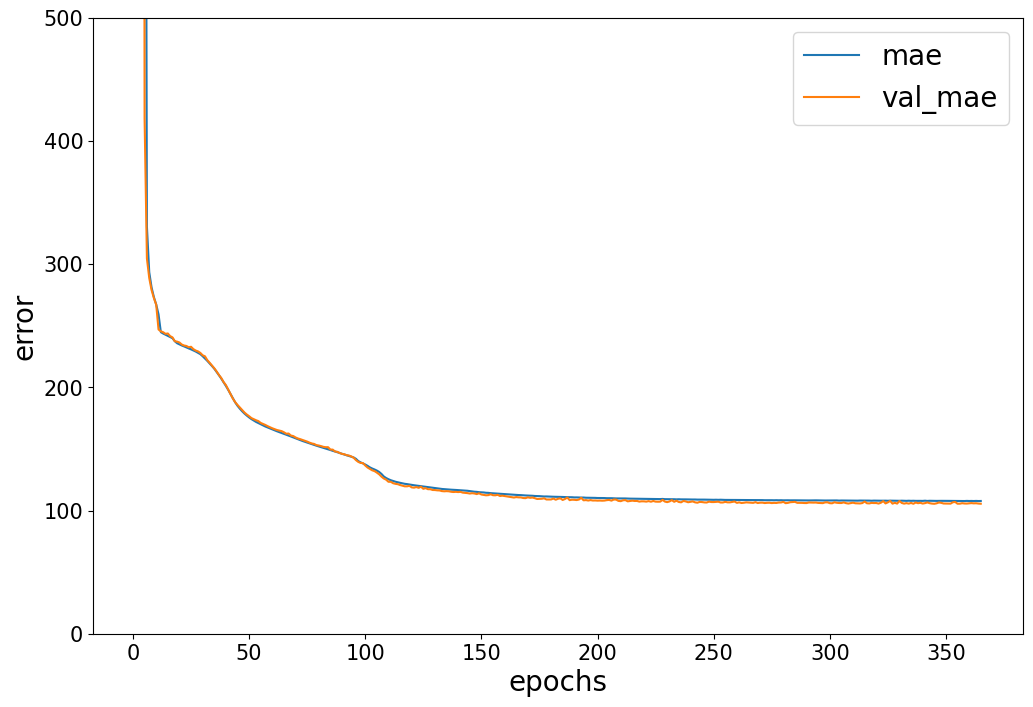

In [47]:
mae = history_dict['mae']
val_mse = history_dict['val_mae']
epochs = range(1, len(mae) + 1)

plt.rcParams["font.size"] = 15
plt.figure(figsize=(12, 8))
plt.plot(epochs, mae, label='mae')
plt.plot(epochs, val_mse, label='val_mae')
plt.xlabel("epochs",fontsize=20)
plt.ylabel("error",fontsize=20)
plt.ylim((0,500))
plt.legend(loc = 'best',fontsize=20)
#plt.savefig('mae_transition.png')
plt.show()

In [48]:
import tensorflow as tf

# MAPEを計算する関数を定義
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # ゼロで割ることを避けるための小さな値
    percentage_error = tf.abs((y_true - y_pred) / (tf.maximum(tf.abs(y_true), epsilon)))
    mape = tf.reduce_mean(percentage_error) * 100.0
    return mape

df7 = model.predict(df_input)
# MAPEを計算
df7 = pd.DataFrame(df7)
df8 = pd.concat([pd.DataFrame(df_output),df7], axis=1)

y_true = tf.constant(df8.iloc[:, 0].values, dtype=tf.float32)
y_pred = tf.constant(df8.iloc[:, 1].values, dtype=tf.float32)
mape_value = mean_absolute_percentage_error(y_true,y_pred)

# 結果を表示
print(f"MAPE: {mape_value.numpy()}%")

4959/4959 [==============================] - 4s 823us/step
MAPE: 2.284228801727295%


In [49]:
weights = [com.get_weights() for com in model.layers[0:]] 
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[2].set_weights(weights[2])

In [50]:
model.save('i_predict CD_whole')

INFO:tensorflow:Assets written to: i_predict CD_whole\assets
